In [125]:
%pylab --no-import-all
%matplotlib inline
from sacla import *

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [126]:
l=log('2019 SACLA - Shotlog.csv')

In [127]:
import pandas as pd
pd.set_option('display.max_rows', 1000)

In [128]:
l

,Run start,last run,Starttime,Endtime,Sample,E_ph,Pre Comment,Pulse Energy,Detector Filter,Beamline filter,...,Sx speed,Sz min,Sz max,Sz spacing,Single_x,Single_y,Single_z,Prof_Y,Prof_X2,Prof_Z1
,#,#,Time,Time,#/desc,keV,desc,uJ,desc,mm Silicon,...,pulse/sec,pulses,pulses,pulses,microns,microns,microns,microns,microns,microns
0,781931,NaN,05:47:29,NaN,1,10.4,NaN,562.0,50um Zink,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,781932,781952.0,09:20:14,09:29:08,15,10.4,background,570.0,50um Zink,0.4,...,1200.0,-10000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
2,781953,781959.0,09:30:16,09:31:57,15,10.4,NaN,570.0,50um Zink,0.3,...,1200.0,-10000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
3,781960,781965.0,09:35:57,09:31:57,15,10.4,NaN,570.0,50um Zink,0.4,...,3600.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
4,781966,781975.0,09:39:18,09:42:37,15,10.4,NaN,570.0,50um Zink,0.5,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
5,781976,781985.0,09:50:41,09:42:37,22x17 empty,10.4,empty 22x17 window,570.0,50um Zink,0.3,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
6,781976,781985.0,09:50:41,09:42:37,none,10.4,NaN,570.0,50um Zink,0.3,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
7,781976,781985.0,09:50:41,09:42:37,none,10.4,Stephan shielded from air scattering after tar...,570.0,50um Zink,0.3,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
8,781976,781985.0,09:50:41,09:42:37,none,10.4,Tais shieded detector from upstream,570.0,50um Zink,0.3,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN


In [134]:
#to run: 97, 82, 83, 84, 87, 88, 93, 94
samples=[
     '10 mid',
     
     'Fe Foil',
    '51, 10 high',
#     '10 agar',
#     '10 low',
#    '5 mid',
   '20 mid',
#     '5 high',
#     '20nm high',
 
]

In [135]:
def submit(r):
    if 'skip' in r['Run start'][0]: return
    runstart=int((r['Run start'][0]))
    runend=int(r['last run'][0])
    if (runend-runstart)<=2: 
        print('skip',r.name)
        return
    run=str(r.name)
    commands=[
        'hostname',
        'echo $PBS_ARRAY_INDEX',
        'cd /home/gorkhover/zimmf',
        f'python analysis2.py  /UserData/gorkhover/TAIS2019/$PBS_ARRAY_INDEX.h5 --workpath /work/gorkhover/zimmf/ --outpath /work/gorkhover/zimmf/weighted/ --delete --simple --ft3d --directrad 50 --allrad --normalize --run {run}'
    ]
    qsub(commands,f'{run}-pfingsten',runstart,runend)
    print(run)
for sample in samples:
    print(sample)
    runs=l.search('Sample',sample)
    isatt=np.array(runs['Beamline filter']!='0')
    runs=runs[isatt]
    runs.apply(submit,axis=1)
    

10 mid
87
Fe Foil
skip 79
80
51, 10 high
82
20 mid
91


In [136]:
!mkdir /work/gorkhover/zimmf/weighted/

In [12]:
l['Sample']

,#/desc
0,1
1,15
2,15
3,15
4,15
5,22x17 empty
6,none
7,none
8,none
9,none


In [132]:
%%writefile analysis2.py
import sacla
import argparse, os
import numpy as np
import idi.reconstruction as recon
from idi.util import *
from funchelper import *
import scipy.ndimage as snd
import os, shutil
import datetime

def isdir(string):
    if os.path.isdir(string):
        return os.path.abspath(string)
    else:
        raise NotADirectoryError(string)

def isfile(string):
    if os.path.isfile(string):
        return os.path.abspath(string)
    else:
        raise FileNotFoundError(string)

def diffdist(*args):
    accum = 0
    for arg in args:
        accum += np.diff(arg) ** 2
    return np.sqrt(accum)

def intensities(detector):
    @asgen
    def intensity(img):
        return np.sum(img)

    return detector.absolute_gain * 3.65 * np.array(list(intensity(detector)))

def getbg(detector):
    accum = accumulator()
    for img in detector:
        dat = np.array(img) * detector.absolute_gain * 3.65
        hits = dat > 2000
        empty = ~(snd.morphology.binary_dilation(hits, snd.morphology.generate_binary_structure(2, 2)))
        accum.add(dat * empty.astype(float), empty)
    return accum.mean

def photonize(img, energy, gain=1, bg=0):
    return np.rint(((np.squeeze(np.array(img)) * gain * 3.65) - bg) / energy)

def photonsstats(detector, bg, energy, thres=10):
    accum = accumulator()
    photonsum = []
    maxphotons = 0
    for n, img in enumerate(detector):

        photons = photonize(img, energy, detector.absolute_gain, bg)
        ps = np.sum(photons)
        if ps > thres:
            accum.add(photons)
            maxphotons = np.maximum(maxphotons, photons)
        photonsum.append(ps)
    return (accum.mean, accum.std, maxphotons, np.array(photonsum))


parser = argparse.ArgumentParser(description='sacla 2019 analysis')
parser.add_argument('inputfile', metavar='inputfile', type=isfile, help='the hdf5 inputfile to process')
parser.add_argument('--outpath', default=None, metavar='path', type=isdir, help='where to save the output (default work dir)')
parser.add_argument('--workpath', default=None, metavar='path', type=isdir, help='the work dir (default input file dir)')
parser.add_argument('--run', default='', dest='run', type=str, help='run info/number to use for outfile')
parser.add_argument('--simple', dest='simple', action='store_true', help='do simple ft correlation')
parser.add_argument('--ft3d', dest='ft3d', action='store_true', help='do 3d ft correlation')
parser.add_argument('--direct', dest='direct', action='store_true', help='do 3d direct correlation (slow!)')
parser.add_argument('--directrad', dest='directrad', type=int, nargs='?', default=False, const=-1, metavar='QMAX', help='do radial direct correlation')
parser.add_argument('--detector', dest='detector', type=str, default='detector_2d_3', metavar='DETECTORNAME', help='name of detector')
parser.add_argument('-e', dest='energy', type=float, default=6450, metavar='ENERGY in ev', help='photon energy')
parser.add_argument('-z', dest='z', type=float, default=10, metavar='DISTANCE in cm', help='detector distance')
parser.add_argument('--threshold', dest='photonsthreshold', type=int, default=500, metavar='THRESHOLD in photons', help='min. photons in image to keep it')
parser.add_argument('--pixelsize', dest='pixelsize', type=float, default=50, metavar='PIXELSIZE in um', help='detector pixelzie')
parser.add_argument('--maximg', dest='maximg', type=int, default=-1, metavar='MAXIMG', help='detector pixelsize')
parser.add_argument('--normalize', dest='normalize', action='store_true', help='normalize each image to zero mean, unity std.')
parser.add_argument('--allimg', dest='allimg', action='store_true', help='store all photonized images in result')
parser.add_argument('--allrad', dest='allrad', action='store_true', help='store radial profiles')
parser.add_argument('--allcorr', dest='allcorr', action='store_true', help='store all 2d corrs)
parser.add_argument('--delete', dest='delete', action='store_true', help='delete workfile')


args = parser.parse_args()
if args.workpath is None:
    args.workpath = os.path.dirname(args.inputfile)
if args.outpath is None:
    args.outpath = args.workpath
workfile = os.path.join(args.workpath, os.path.basename(args.inputfile))
if os.path.isfile(workfile):
    print(f' File {workfile} exists, not copying to workdir.', flush=True)
else:
    print(f' copying input to {workfile}', flush=True)
    shutil.copy(args.inputfile, workfile)
outfile=os.path.join(args.outpath,datetime.datetime.now().strftime(f'{args.run}-{os.path.splitext(os.path.basename(args.inputfile))[0]}-%y%m%d-%H%M%S.npz'))

run = sacla.saclarun(workfile, settings=sacla.Tais2019)
print(f'{len(run)} images in input')
detector = getattr(run, args.detector)
energy = args.energy
z = (args.z * 1e-2) / (args.pixelsize * 1e-6)
nmax = np.inf if args.maximg == -1 else args.maximg
print(vars(args))
print('init done', flush=True)

# filter by distance between shots
setdist = np.percentile(diffdist(run.sampleX), 75)
mindist = setdist * 0.7
distok = np.concatenate(([0], diffdist(run.sampleX, run.sampleZ))) > mindist
shots = run[distok]
detector = getattr(shots, args.detector)
print(f'distance done, {len(shots)} remaining')

#background
bg = getbg(detector)
print('background done', flush=True)

#photons statistics for filtering
meanphotons, stdphotons, maxphotons, photonsum = photonsstats(detector, bg, energy, args.photonsthreshold)
intok = photonsum > args.photonsthreshold
nphotonsmin = np.rint(np.percentile(photonsum[intok], 1))
nphotonsmax = np.rint(np.percentile(photonsum[intok], 99))

intok = np.logical_and.reduce((intok, nphotonsmin < photonsum, photonsum < nphotonsmax))
mask = meanphotons > (0.1 * np.mean(meanphotons))
shots = shots[intok]
detector = getattr(shots, args.detector)
print(f'intensity filter done, keep >{nphotonsmin} && <{nphotonsmax}. {len(shots)} remaining')

#now redo the statistics..
meanphotons, stdphotons, maxphotons, photonsum = photonsstats(detector, bg, energy, args.photonsthreshold)
print(f'statistics done')

accum = {'simple': accumulator(), 'ft3d': accumulator(), 'direct': accumulator(), 'directrad': accumulator()}

print('start recon...', flush=True)

allimg=[]
alldirectrad=[]
allsimplerad=[]

shotmean=[]
shotstd=[]
directfunc=None
for n, img in enumerate(detector):
    if n >= nmax:
        break
    photons = photonize(img, energy, detector.absolute_gain, bg) / meanphotons
    photons[~mask] = 0
    if args.allimg:
        allimg.append(np.array(photons))
    cshotmean=np.mean(photons[mask])
    cshotstd=np.std(photons[mask])
    if args.normalize:
        photons=photons-cshotmean
        photons=photons/cshotstd
        weight=cshotstd**2
    else:
        weight=1
    shotmean.append(cshotmean)
    shotstd.append(cshotstd)   
    if args.simple:
        csimple=recon.simple.corr(photons)
        accum['simple'].add(csimple*weight,weight)
        if args.allrad:
            allsimplerad.append(radial_profile(csimple,np.array(csimple.shape)//2))
    if args.ft3d:
        accum['ft3d'].add(recon.ft.corr(photons, z)*weight,weight)
    if args.direct:
        accum['direct'].add(recon.direct.corr(photons, z)*weight,weight)
    if args.directrad:
        if directfunc is None:
            qmax=max(photons.shape) if args.directrad == -1 else args.directrad 
            print(f'qmax: {qmax}')
            directfunc=recon.newrad.corrfunction(photons.shape, z, qmax)
        cdirectrad=directfunc(photons)
        accum['directrad'].add(cdirectrad*weight,weight)
        if args.allrad: alldirectrad.append(cdirectrad)
    if n == 0:
        for a in accum:
            print(a, accum[a].shape)
    if n % 10 == 0:
        print(n, end=' ',flush=True)

allimg=np.array(allimg)
allcors=np.array(allcors)
alldirectrad=np.array(alldirectrad)
allsimplerad=np.array(allsimplerad)
shotstd=np.array(shotstd)
shotmean=np.array(shotmean)

print()
print(f'start saving to {outfile}')
tosave = vars(args)
tosave.update(
    {
        'workfile': workfile,
        'outfile': outfile,
        'mask': mask,
        'meanphotons': meanphotons,
        'stdphotons': stdphotons,
        'maxphotons': maxphotons,
        'nphotonsmax': nphotonsmax,
        'nphotonsmin': nphotonsmin,
        'photonsum': photonsum,
        'bg': bg,
        'mindist': mindist,
        'allimg':allimg,
        'shotmean':shotmean,
        'shotstd':shotstd,
        'Nimg':n,
        'simplerad_all':allsimplerad,
        'directrad_all':alldirectrad
    }
)
tosave.update({f'{k}_mean': v.mean for k, v in accum.items()})
tosave.update({f'{k}_std': v.std for k, v in accum.items()})
np.savez_compressed(outfile, **tosave)

if args.delete:
    print(f'deleting {workfile}', flush=True)
    os.remove(workfile)

print('done!')


Writing analysis2.py


In [131]:
import os

In [94]:
!python analysis.py  /UserData/gorkhover/TAIS2019/782533.h5 --workpath /work/gorkhover/zimmf/ --outpath /work/gorkhover/tmp/ --directrad 100 --simple --maximg 5 --normalize --allrad

 copying input to /work/gorkhover/zimmf/782533.h5
5000 images in input
{'inputfile': '/UserData/gorkhover/TAIS2019/782533.h5', 'outpath': '/work/gorkhover/tmp', 'workpath': '/work/gorkhover/zimmf', 'run': '', 'simple': True, 'ft3d': False, 'direct': False, 'directrad': 100, 'detector': 'detector_2d_3', 'energy': 6450, 'z': 10, 'photonsthreshold': 500, 'pixelsize': 50, 'maximg': 5, 'allimg': False, 'normalize': True, 'allrad': True}
init done
distance done, 3860 remaining
background done
intensity filter done, keep >8481.0 && <108443.0. 3782 remaining
statistics done
start recon...
analysis.py:146: RuntimeWarning: divide by zero encountered in true_divide
  photons = photonize(img, energy, detector.absolute_gain, bg) / meanphotons
analysis.py:146: RuntimeWarning: invalid value encountered in true_divide
  photons = photonize(img, energy, detector.absolute_gain, bg) / meanphotons
qmax: 100
simple (2048, 1024)
ft3d 0
direct 0
directrad (100,)
0 analysis.py:146: RuntimeWarning: divide by z

In [115]:
l=np.load('/work/gorkhover/zimmf/782533-190517-102040.npz')

In [117]:
mp=l['meanphotons']

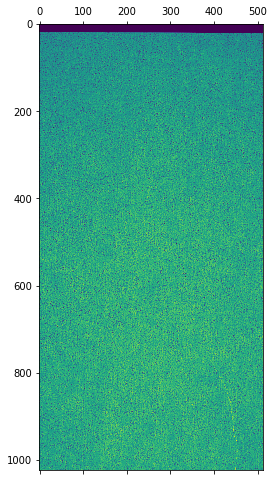

In [118]:
plt.matshow(mp)

In [100]:
l["directrad"].shape

(5, 100)

(array([1.340e+02, 3.180e+02, 6.830e+02, 1.035e+03, 9.230e+02, 5.220e+02,
        2.020e+02, 4.000e+01, 2.000e+00, 1.000e+00]),
 array([  2240. ,  17346.3,  32452.6,  47558.9,  62665.2,  77771.5,
         92877.8, 107984.1, 123090.4, 138196.7, 153303. ]),
 <a list of 10 Patch objects>)

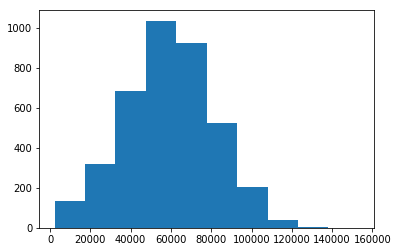

In [13]:
plt.hist(l['photonsum'])

In [246]:
imgs=l['allimg']
c=0
norm=recon.simple.corr((np.sum(imgs,axis=0)>0).astype(float))
for i,img in enumerate(imgs):
    c=c+recon.simple.corr(img)/norm
    print(np.nanmin(c[400:600,400:600]/(i+1)),np.nanmedian(c[400:600,400:600]/(i+1)),np.nanmax(c[400:600,400:600]/(i+1)))
r=c/(i+1)

/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in add
  """


0.2125824204324992 0.25256401799179073 0.2916525470121851
0.257794375944876 0.2873900387082363 0.32413233844927913
0.19635081001891655 0.21820326196647816 0.24192463312912568
0.2727926195532562 0.2935624555957791 0.31963073692305843
0.28854625591747685 0.3086643913139342 0.33108987851284954
0.3512658543812312 0.3707921870710101 0.39070134135048296
0.35787961549823283 0.37624079709000025 0.39476641290647124
0.36089952119391333 0.3778986240181882 0.3979691630719878
0.3672728632484894 0.3834976738527634 0.4010114740644258
0.38088549832234636 0.39724994884420173 0.4146434887792734
0.4332973694583126 0.4497985103230686 0.4675641513448078
0.44286472454432174 0.45812149731496044 0.47526467521397125
0.49243749394341757 0.509893859670139 0.5277185914477183
0.469723410056342 0.4856366201146751 0.5029165082707606
0.48782639281202206 0.5033614462459826 0.5200924158179847
0.5096365901983859 0.5238159954080311 0.5398313417439337
0.5422378851285136 0.5561965079656201 0.5721217914007376
0.536123312779

In [249]:
np.nanmedian(r[400:-400,400:-400]),np.nanmin(r[400:-400,400:-400]),np.nanmax(r[400:-400,400:-400])

(0.8829890778245282, 0.8749633143348212, 8.991288659456073)

In [ ]:
r=r-np.nanmedian(r[800:-800,400:-400])

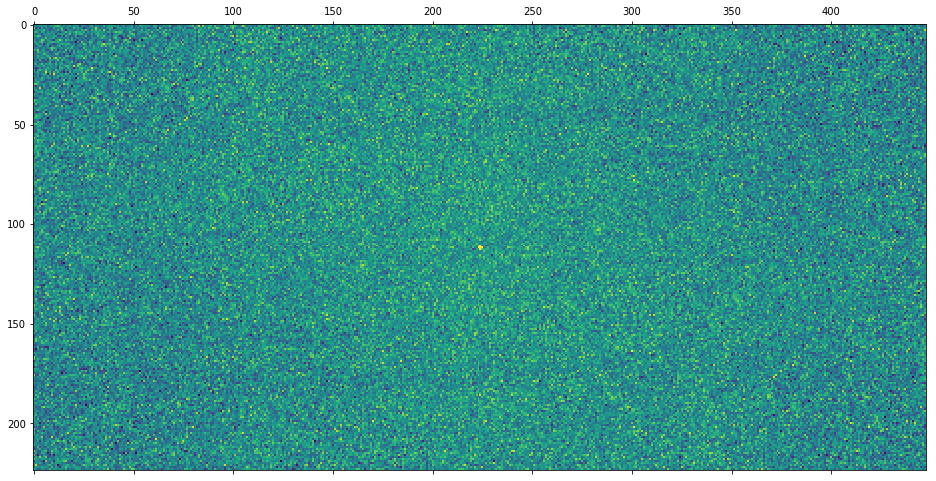

In [263]:
plt.rcParams['figure.figsize']=(15,15)

plt.matshow(r[800:-800,400:-400].T,vmin=-0.005,vmax=0.005)

In [208]:
c=l['simple_mean']
norm=recon.simple.corr((l['mask']).astype(float))
r=c/norm
np.median(r[norm>1e5])

/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


0.8822164072757648

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


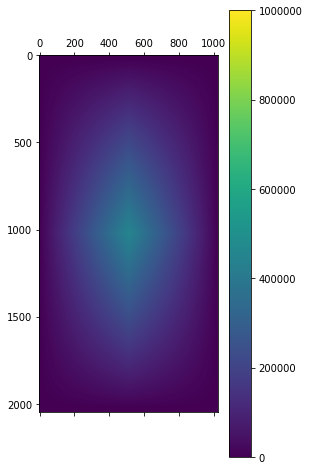

In [136]:
%pylab --no-import-all
%matplotlib inline
plt.matshow(l['simple_mean'],vmax=1e6)
plt.colorbar()

In [137]:
import idi.reconstruction as recon
norm=recon.simple.corr(l['mask'])
r=l['simple_mean']/norm

/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [159]:
from idi.util import radial_profile

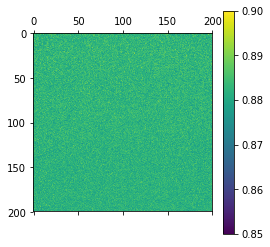

In [161]:
plt.matshow(r[400:600,400:600],vmax=0.9,vmin=0.85)
plt.colorbar()

(0.85, 0.9)

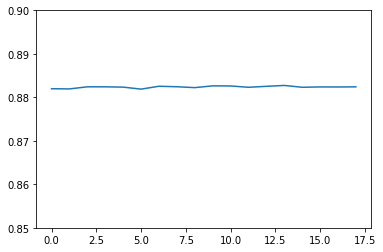

In [174]:
plt.plot(radial_profile(r,np.array(r.shape)//2)[2:20])
plt.ylim([0.85,0.9])

In [ ]:
plt.plot(radial_profile(r,np.array(r.shape)//2)[2:20]l['simple_mean']

In [14]:
l['maximg']

array(100)

In [113]:
l

,Run start,last run,Starttime,Endtime,Sample,E_ph,Pre Comment,Pulse Energy,Detector Filter,Beamline filter,...,Sx speed,Sz min,Sz max,Sz spacing,Single_x,Single_y,Single_z,Prof_Y,Prof_X2,Prof_Z1
,#,#,Time,Time,#/desc,keV,desc,uJ,desc,mm Silicon,...,pulse/sec,pulses,pulses,pulses,microns,microns,microns,microns,microns,microns
0,781931,NaN,05:47:29,NaN,1,10.4,NaN,562.0,50um Zink,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,781932,781952.0,09:20:14,09:29:08,15,10.4,background,570.0,50um Zink,0.4,...,1200.0,-10000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
2,781953,781959.0,09:30:16,09:31:57,15,10.4,NaN,570.0,50um Zink,0.3,...,1200.0,-10000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
3,781960,781965.0,09:35:57,09:31:57,15,10.4,NaN,570.0,50um Zink,0.4,...,3600.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
4,781966,781975.0,09:39:18,09:42:37,15,10.4,NaN,570.0,50um Zink,0.5,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
5,781976,781985.0,09:50:41,09:42:37,22x17 empty,10.4,empty 22x17 window,570.0,50um Zink,0.3,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
6,781976,781985.0,09:50:41,09:42:37,none,10.4,NaN,570.0,50um Zink,0.3,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
7,781976,781985.0,09:50:41,09:42:37,none,10.4,Stephan shielded from air scattering after tar...,570.0,50um Zink,0.3,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
8,781976,781985.0,09:50:41,09:42:37,none,10.4,Tais shieded detector from upstream,570.0,50um Zink,0.3,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
